# Create yearly mill usage profile based on measured usage

This notebook will follow a very similar approach to the welder notebook here: https://github.com/RadiantLabs/microgrid-appliance-analysis/blob/master/scripts/usage_profiles/welder_usage_profile.ipynb 

I will include a lot less context in this notebook for now. I can fill it out later if needed.

### Definitions
**Usage Profile**: A usage profile is a unitless series of how often the mill is used on an hourly basis throughout a year. Being unitless allows us to apply costs, power or other factors to generate load, throughput or cost profiles. 

**day_hour**: Monday at 2pm is a single `day_hour` for example. Monday at 3pm is a different `day_hour`. There are 24 hours x 7 days = 168 `day_hour`s.

### General Steps
1. Import measured usage data from a mill. This data is in 2 minute increments and has a usage value associated with it. 
2. Filter out any noise, where any usage value below 100 would be considered "off". Count anything greater than that as "on" (assign a value of 1) for that 2 minute interval.
3. Resample 2 minute data to 1 hour data, summing new usage values. 
4. Group data by `day_hour`s and export for web app
5. Generate a yearly profile by randomly sampling measured `day_hour`s and applying them to the rest of the year.
6. Compare stats of yearly usage profile to measured usage profile to make sure we made reasonable assumptions

We probably don't need to interpolate, since we have 5-6 measured values per `day_hour`

### TODO
* Decide on what the max RPM is. Do quintiles and take the top 20% as full load? 
> Amanda: is the engine running harder than full rated load during these times? I think so, because it would then mean that most of the activity is happening around 80% of full rated load, which is normal for a diesel engine
* Come up power-to-RPM curve. From common mills (https://www.alibaba.com/product-detail/Changfa-type-20-hp-S1115-single_60629667381.html?spm=a2700.7724857.normalList.30.48f321e0kzd6H9), we can see that 16.2kW = 2200 RPM (which would imply this mill is running at half speed most of the time)
> Amanda: I think that actually makes a lot of sense. … so 2200 RPM = 100% load
* Ask if Timestamp is in GMT (I am assuming it is)

* Add photos of the mill and measuring device(?)

### Running this notebook
Jupyter notebooks are very flexible but have problems with out-of-order function executions.
For example, dropping a column once and then trying to drop the same column again because
you're evaluating the same cell will throw an error. 

Go to Cell > Run All from the menu often or if having problems. For final output, always run it.

## Setup & Library Imports

In [635]:
# Reset all variables so that we can 'run all cells' and not get unused variables hanging around
%reset -f

# Most of this comes with anaconda distribution. I thinkt the only one 
# you have to install is:
# conda install pivottablejs
import pandas as pd
import numpy as np
from scipy.stats import mode
from pivottablejs import pivot_ui
from collections import defaultdict
from functools import partial
import random
import json
import pytz

# Should have pandas 0.23 or greater. If not and you're using Anaconda for packages, 
# do this in the terminal: `conda update pandas`
pd.__version__    

'0.23.4'

## Import Mill Data

In [636]:
excel_file_path = 'data/RiceHulling_LP_Tanzania 20180908-20181018.xlsx'
sheet_name = 'RiceHulling_LP_Tanzania'

# Import Excel file, specify the sheet & import it into a Pandas Dataframe.
# df is short for Pandas DataFrame - it makes it clearer what this datastructure is
df_measured_2min = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Rename columns so they are shorter and easier to work with.
df_measured_2min = df_measured_2min.rename(columns={'Timestamp': 'time_gmt', 'Value RPM for 2 min)': '2min_count'})

# Keep only relevant columns
df_measured_2min = df_measured_2min[['time_gmt', '2min_count']]
df_measured_2min.head()

,time_gmt,2min_count
0,2018-09-07 08:38:44,0
1,2018-09-07 08:40:44,0
2,2018-09-07 08:42:44,0
3,2018-09-07 08:44:44,0
4,2018-09-07 08:46:44,0


In [637]:
df_measured_2min.shape # (rows, columns)

(30292, 2)

## Convert Timezone

In [638]:
# To see all timezones available (but select only the first 55 to see Africa): 
# pytz.all_timezones[0:55]  

In [639]:
# There was no Tanzania listed. Nairobi is +3 which is the same as Tanzania
# There should not be a problem with daylight savings time - from my research neither observe it
tanzania_tz = pytz.timezone('Africa/Nairobi')

In [640]:
# Convert date string to proper datetime so we can work with timezones
df_measured_2min['time_gmt'] = pd.to_datetime(df_measured_2min['time_gmt'])

In [641]:
# Add local time
df_measured_2min['time_local'] = df_measured_2min['time_gmt'].dt.tz_localize('utc').dt.tz_convert(tanzania_tz)
df_measured_2min = df_measured_2min
df_measured_2min.head()

,time_gmt,2min_count,time_local
0,2018-09-07 08:38:44,0,2018-09-07 11:38:44+03:00
1,2018-09-07 08:40:44,0,2018-09-07 11:40:44+03:00
2,2018-09-07 08:42:44,0,2018-09-07 11:42:44+03:00
3,2018-09-07 08:44:44,0,2018-09-07 11:44:44+03:00
4,2018-09-07 08:46:44,0,2018-09-07 11:46:44+03:00


## Calculate RPM
The mill sensor measures rotations every 2 minutes. Calculate RPMs by dividing by 2

In [642]:
def count_to_rpm(count):
    return round(count / 2)

df_measured_2min['rpm'] = df_measured_2min['2min_count'].apply(count_to_rpm)
df_measured_2min.sample(10)

,time_gmt,2min_count,time_local,rpm
3784,2018-09-12 14:33:42,0,2018-09-12 17:33:42+03:00,0
11288,2018-09-23 00:35:17,0,2018-09-23 03:35:17+03:00,0
16470,2018-09-30 05:00:16,0,2018-09-30 08:00:16+03:00,0
26275,2018-10-13 19:35:44,0,2018-10-13 22:35:44+03:00,0
11682,2018-09-23 13:37:06,0,2018-09-23 16:37:06+03:00,0
11553,2018-09-23 09:19:06,0,2018-09-23 12:19:06+03:00,0
2452,2018-09-10 18:18:33,0,2018-09-10 21:18:33+03:00,0
24148,2018-10-10 20:41:44,0,2018-10-10 23:41:44+03:00,0
12658,2018-09-24 22:09:06,0,2018-09-25 01:09:06+03:00,0
29170,2018-10-17 20:05:44,0,2018-10-17 23:05:44+03:00,0


## Explore Data

In [643]:
# The data is skewed because most of it is zeros:
df_measured_2min.describe()

,2min_count,rpm
count,30292.000000,30292.000000
mean,148.044005,74.021425
std,516.505556,258.252519
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,2242.000000,1121.000000


In [644]:
# Filter out all zeros and very low RPMs and look at it again:
df_measured_nozeros = df_measured_2min[df_measured_2min['rpm'] > 100]
df_measured_nozeros.describe()

,2min_count,rpm
count,2496.000000,2496.000000
mean,1793.167067,896.576522
std,536.436711,268.236554
min,208.000000,104.000000
25%,1684.500000,842.000000
50%,2032.000000,1016.000000
75%,2126.000000,1063.000000
max,2242.000000,1121.000000


In [645]:
# pivot_ui(df_measured_nozeros, 
#          rows=['2min_count'],
#          rendererName="Table",
#          aggregatorName="Count")

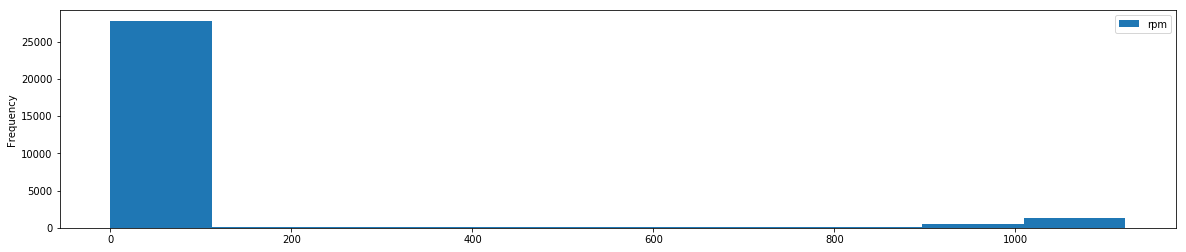

In [646]:
# Plot histogram of rpm including zeros
df_measured_2min.plot.hist(y='rpm', figsize=(20, 4))

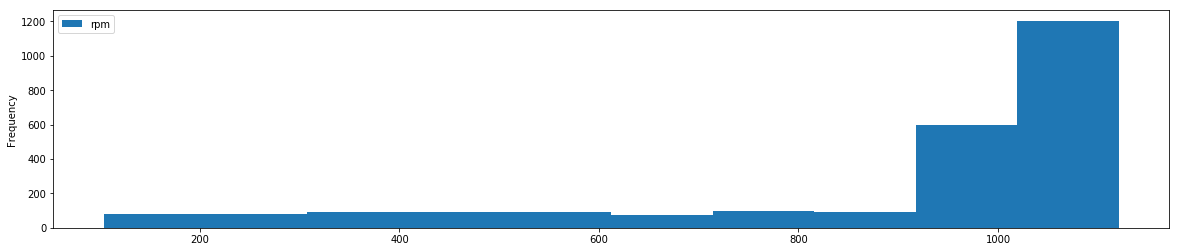

In [647]:
# Plot histogram of rpm excluding zeros and low RPMs
df_measured_nozeros.plot.hist(y='rpm', figsize=(20, 4))

In [648]:
# Most common value (mode):
df_measured_nozeros['rpm'].value_counts().idxmax()

1048

#### Thoughts
* We're seeing the RPM average and mode as ~1000. We think the max RPM is 2200. We are measuring rotations every 2 minutes but 2 minutes is fairly long. Is it possible these mills cycle on and off (or low) within those 2 minutes? For example, they could run at max for 30 seconds, spin down to low RPMs for 30, then spin back up to max continuously? 
    1. The data could support that type of cycling if that behavior was programmed into the mill
    2. The data is too consistent to support people manually cycling these mills. I would expect more variance in the distributions of RPMs.

#### Questions:
* Do I want to split this into rpm quintiles (fifths) so I can look at the 80% usage as max load? Not really - how people normally operate the mill is independent of the kW or throughput based on RPM. 
* Let's say this mill is 16.2kW @ 2200 RPM. 
* How do I resample from 2 min data to 1 hour intervals? With the welder, we considered it either "on" or "off" and those can add. We can't sum RPMs. So for every 2 min interval, do I assign it a usage percent? So if maxed out, 1. If running at 80%, assign it to 0.8. What do I use as 100%


## Approach to convert RPM to unitless usage counts
RPMs relate to 3 quantities that we care about:
* kW
* kWh
* Grain throughput

These quantities are directly related to costs and revenue for the appliance owner and grid operator. We have measured revolution count in 2-minute intervals. The average RPM is half the number of mill revolutions.

However, if we want to work with hourly intervals, then we can't add up RPMs to get the total RPMs within an hour. We have a few options:
1. Average the RPMs across the hour. If the mill runs for 30 minutes at 1200 RPMs, then the average would be 600 RPMs. Grain throughput and kW likely have a non-linear relationship to RPMs, so this would really distort the results.
2. Assign a unitless usage value to each minute interval. If the mill is running at full production (throughput and kW), then we can assign it a value of 1 (2 for a 2-minute interval). If the mill is running at 80%, we can assign it 0.8 and so on. In order to do this we need to know the relationship between RPM, throughput and kW. 

The second approach is what I will use.

### Throughput vs. kW
To calculate kW (and therefore kWh) and throughput, we need to know how RPM relates to these two factors. It's possible that you could use the same utilization factor to calculate both, but we (I) have no reason to assume that. So we will calculate different utilization factors for kW and throughput.

## RPM to unitless utilization factors
This mill is likely rated at 16.2kW @ 2200 RPM. Let's assume some function that relates it's utilization given an RPM.

In [649]:
# Until we can get ahold of performance curves for rpm vs kW and rpm vs throughput,
# let's take an educated guess at how they relate.
# We may want to filter very low RPMs out. A slow motor still uses power and mills grain, 
# so I don't know what the cutoff would be.

# This is the function from Amanda's spreadsheet. 
def rpm_to_kw_utilization(rpm, full_capacity=1110):
    """
    Convert RPM to a kW utilization factor. 
    """
    return round(rpm / full_capacity, 5)

rpm_to_kw_utilization(1121)

1.00991

In [650]:
# Until we have better data, assume the utilization factors are the 
# same between kW and grain
def rpm_to_grain_utilization(rpm, full_capacity=1110):
    """
    Convert RPM to a grain milled utilization factor
    """
    return round(rpm / full_capacity, 5)

rpm_to_grain_utilization(1121)

1.00991

In [651]:
# The utilization factors relate RPMs to kW (or throughput) for *one minute*.
# We are working with 2 minute intervals, so we need to account for both
# minutes of usage by multiplying the factor by 2.
df_measured_2min['kw_factor'] = df_measured_2min['rpm'] \
                                        .apply(rpm_to_kw_utilization) \
                                        .apply(lambda factor: 2 * factor)
df_measured_2min['grain_factor'] = df_measured_2min['rpm'] \
                                        .apply(rpm_to_grain_utilization) \
                                        .apply(lambda factor: 2 * factor)
df_measured_2min[30279:30290]

,time_gmt,2min_count,time_local,rpm,kw_factor,grain_factor
30279,2018-10-19 09:03:44,0,2018-10-19 12:03:44+03:00,0,0.00000,0.00000
30280,2018-10-19 09:05:44,0,2018-10-19 12:05:44+03:00,0,0.00000,0.00000
30281,2018-10-19 09:07:44,324,2018-10-19 12:07:44+03:00,162,0.29190,0.29190
30282,2018-10-19 09:09:44,2150,2018-10-19 12:09:44+03:00,1075,1.93694,1.93694
30283,2018-10-19 09:11:44,2156,2018-10-19 12:11:44+03:00,1078,1.94234,1.94234
30284,2018-10-19 09:13:44,2143,2018-10-19 12:13:44+03:00,1072,1.93154,1.93154
30285,2018-10-19 09:15:44,2150,2018-10-19 12:15:44+03:00,1075,1.93694,1.93694
30286,2018-10-19 09:17:44,2165,2018-10-19 12:17:44+03:00,1082,1.94954,1.94954
30287,2018-10-19 09:19:44,2152,2018-10-19 12:19:44+03:00,1076,1.93874,1.93874
30288,2018-10-19 09:21:44,1902,2018-10-19 12:21:44+03:00,951,1.71352,1.71352


## Resample 2 minute to hourly intervals

In [652]:
# First we need to set the dataframe index to be the time_local datetime
df_measured_2min_index = df_measured_2min.set_index('time_local')
df_measured_2min_index[30279:30283]

,time_gmt,2min_count,rpm,kw_factor,grain_factor
time_local,,,,,
2018-10-19 12:03:44+03:00,2018-10-19 09:03:44,0,0,0.00000,0.00000
2018-10-19 12:05:44+03:00,2018-10-19 09:05:44,0,0,0.00000,0.00000
2018-10-19 12:07:44+03:00,2018-10-19 09:07:44,324,162,0.29190,0.29190
2018-10-19 12:09:44+03:00,2018-10-19 09:09:44,2150,1075,1.93694,1.93694


In [653]:
df_measured_2min_index.shape

(30292, 5)

In [654]:
# Resample while summing every 2-min interval within an hour ('H')
# Drop the now-unused 2min_count
# GMT time will automatically be dropped since you can't sum it
df_measured = df_measured_2min_index.resample('H').sum().drop(columns=['2min_count'])

df_measured.shape  # (rows, columns) where column count doesn't include the index

(1010, 3)

## Add hour, day of week, day_hour columns 
These columns will be used later for generating yearly usage profile and aggregate stats.

In [655]:
# Helper functions for making and matching day_hour columns

def shorten_day_name(day_string):
    """Shorten a day name to the first 4 letters (1Saturday => 1sat)
    This requires a string passed in.
    """
    return day_string[0:4].lower()

def composite_val(day_name, hour):
    """Generate a composite string value that can be used for dictionary 
    keys or other uses.
    For example, 1Saturday at 10am => 1sat_10
    """
    padded_hour = str(hour).zfill(2)
    return "{}_{}".format(shorten_day_name(day_name), padded_hour)

In [656]:
# Add the name of the day of the week to the dataframe (Saturday).
# Prepend that name with a number of the day of the week.
# Monday is 0, Tuesday is 1 and so on. This will allows tools to 
# order the days so they are in order: 0Monday, 1Tuesday, otherwise 
# they will be ordered alphabetical.
df_measured["day"] = df_measured.index.dayofweek.map(str) + df_measured.index.day_name()
df_measured["day"] = df_measured["day"].apply(shorten_day_name)

# Add hour of day (as a number)
df_measured['hour_of_day'] = df_measured.index.hour 

# Add day_hour. For example: 4fri_10
# Possible source of confusion: 
# 4fri is just friday. 4fri_10 is Friday at 10am. 
df_measured["day_hour"] = df_measured.apply(lambda row: composite_val(row['day'], row['hour_of_day']), axis=1)

df_measured.sample(10)

,rpm,kw_factor,grain_factor,day,hour_of_day,day_hour
time_local,,,,,,
2018-09-16 05:00:00+03:00,0,0.00000,0.00000,6sun,5,6sun_05
2018-09-29 23:00:00+03:00,0,0.00000,0.00000,5sat,23,5sat_23
2018-10-08 03:00:00+03:00,2395,4.31532,4.31532,0mon,3,0mon_03
2018-09-22 10:00:00+03:00,18762,33.80542,33.80542,5sat,10,5sat_10
2018-10-16 02:00:00+03:00,0,0.00000,0.00000,1tue,2,1tue_02
2018-09-12 00:00:00+03:00,0,0.00000,0.00000,2wed,0,2wed_00
2018-10-05 08:00:00+03:00,14474,26.07926,26.07926,4fri,8,4fri_08
2018-09-09 09:00:00+03:00,14147,25.49010,25.49010,6sun,9,6sun_09
2018-10-05 00:00:00+03:00,0,0.00000,0.00000,4fri,0,4fri_00


## Generate data for yearly usage profile sampling

In [657]:
def create_usage_profile_data(df, column):
    """
    Create a dictionary, where each key is a day_hour and each value 
    is a list of measured welder_on_count values. 
    Takes a Pandas dataframe and returns a python dictionary that can be 
    encoded into JSON for other applications.
    We may be able to use groupby for a more succinct function, but this works
    """
    dict = defaultdict(list)
    for index, row in df.iterrows():
        key = row['day_hour']
        dict[key].append(row[column])
    return dict

In [658]:
measured_usage_kw_factors = create_usage_profile_data(df_measured, 'kw_factor')
measured_usage_kw_factors

defaultdict(list,
            {'0mon_00': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             '0mon_01': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             '0mon_02': [0.0, 10.668460000000001, 2.92072, 0.0, 0.0, 0.0],
             '0mon_03': [0.0, 0.0, 2.07206, 9.25224, 4.31532, 0.0],
             '0mon_04': [0.0, 0.0, 0.0, 0.0, 2.72794, 0.0],
             '0mon_05': [10.27206, 0.0, 0.0, 0.0, 11.679260000000001, 0.0],
             '0mon_06': [5.54234,
              1.81982,
              12.075680000000002,
              10.54954,
              0.0,
              0.0],
             '0mon_07': [0.0036, 0.0, 0.0, 6.409020000000001, 0.0, 3.45046],
             '0mon_08': [19.13698, 2.56218, 2.41802, 0.0, 3.6036, 0.0],
             '0mon_09': [8.27928,
              11.50092,
              1.86848,
              10.95678,
              1.01802,
              6.8018],
             '0mon_10': [19.410839999999997,
              29.52252,
              20.4829,
              16.268459999999997,
           

In [659]:
measured_usage_grain_factors = create_usage_profile_data(df_measured, 'grain_factor')
measured_usage_grain_factors

defaultdict(list,
            {'0mon_00': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             '0mon_01': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             '0mon_02': [0.0, 10.668460000000001, 2.92072, 0.0, 0.0, 0.0],
             '0mon_03': [0.0, 0.0, 2.07206, 9.25224, 4.31532, 0.0],
             '0mon_04': [0.0, 0.0, 0.0, 0.0, 2.72794, 0.0],
             '0mon_05': [10.27206, 0.0, 0.0, 0.0, 11.679260000000001, 0.0],
             '0mon_06': [5.54234,
              1.81982,
              12.075680000000002,
              10.54954,
              0.0,
              0.0],
             '0mon_07': [0.0036, 0.0, 0.0, 6.409020000000001, 0.0, 3.45046],
             '0mon_08': [19.13698, 2.56218, 2.41802, 0.0, 3.6036, 0.0],
             '0mon_09': [8.27928,
              11.50092,
              1.86848,
              10.95678,
              1.01802,
              6.8018],
             '0mon_10': [19.410839999999997,
              29.52252,
              20.4829,
              16.268459999999997,
           

## Export usage data for web app

In [660]:
with open('data/rice_mill_kw_factor_generator_data.json', 'w') as fp:
    json.dump(measured_usage_kw_factors, fp)
    
with open('data/rice_mill_grain_factor_generator_data.json', 'w') as fp:
    json.dump(measured_usage_grain_factors, fp)

## Generating yearly usage profile
Now that we have usage profile data, generate a complete year's usage profile

In [661]:
def create_year_range_df(year=2018):
    """
    Creates a dataframe with a full year's dates as the index. 
    Add extra derived columns based on that datetime index: 
    (hour_of_year, day, hour_of_day, day_hour).
    This dataframe does not contain any appliance data
    """
    start_date_str = '1/1/{}'.format(year + 1)
    start_date = pd.to_datetime(start_date_str) - pd.Timedelta(days=365)
    hourly_periods = 8760
    date_range = pd.date_range(start_date, periods=hourly_periods, freq='H')
    year_hours = list(range(len(date_range)))
    
    # Create a full year with a datetime index (8760 hours)
    df_year = pd.DataFrame({"hour_of_year": year_hours}, index=date_range)
    
    # Now add day of week, hour of day and day_hour columns
    df_year['day'] = df_year.index.dayofweek.map(str) + df_year.index.day_name()
    df_year['day'] = df_year["day"].apply(shorten_day_name)
    df_year['hour_of_day'] = df_year.index.hour
    df_year["day_hour"] = df_year.apply(lambda row: composite_val(row['day'], row['hour_of_day']), axis=1)
    return df_year

# Uncomment these to test results. 
# This function is called from generate_usage_profile() 
# df_year_example = create_year_range_df()
# df_year_example.head()

In [662]:
def sample_usage_index(measured_usage, row):
    """
    Takes the measured usage dictionary and a dataframe row
    from the empty yearly profile created in create_year_range_df. 
    Using the day_hour from that dataframe row, take a random
    sample of the same day_hour from the measured data.
    """
    choice_index_range = range(len(measured_usage[row['day_hour']]))
    return random.choice(choice_index_range)
    
# TODO:
# For any given row of the df, sample the day_hour value index
# I could return a dictionary or tuple
# Either way I need to iterate row-by-row over the df:
#     for index, row in df.iterrows():
#         key = row['day_hour']
#         dict[key].append(row[column])

def generate_usage_profile(kw_factors, grain_factors, year=2018):
    """
    First create a dataframe with a datetime index spanning a full
    year of hourly intervals. Then apply appliance values based on 
    the measured usage dictionary.
    Takes the measured usage dictionary and optional year, returns
    a dataframe of hourly intevals with sampled appliance values
    """
    df_year = create_year_range_df(year)
    sample_usage_index(kw_factors)
    
    df_year['kw_factor'] = df_year.apply(partial(sample_usage_index, kw_factor), axis=1)
    # df_year['grain_factor'] = df_year.apply(partial(sample_usage_index, grain_factor), axis=1) 
    return df_year

df_generated_usage_profile = generate_usage_profile(measured_usage_kw_factors, measured_usage_grain_factors)
df_generated_usage_profile.head(10)

,hour_of_year,day,hour_of_day,day_hour
2018-01-01 00:00:00,0,0mon,0,0mon_00
2018-01-01 01:00:00,1,0mon,1,0mon_01
2018-01-01 02:00:00,2,0mon,2,0mon_02
2018-01-01 03:00:00,3,0mon,3,0mon_03
2018-01-01 04:00:00,4,0mon,4,0mon_04
2018-01-01 05:00:00,5,0mon,5,0mon_05
2018-01-01 06:00:00,6,0mon,6,0mon_06
2018-01-01 07:00:00,7,0mon,7,0mon_07
2018-01-01 08:00:00,8,0mon,8,0mon_08
2018-01-01 09:00:00,9,0mon,9,0mon_09


In [663]:
a = [1, 2, 3, 4, 5]
index = random.randint(0,len(a)-1)

In [664]:
index

1

In [665]:
range(len(a))

range(0, 5)

In [666]:
random.randint(range(len(a)))

TypeError: randint() missing 1 required positional argument: 'b'